In [2]:
pip install -q astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00


PHOTOMETRIC REDSHIFT ESTIMATION PIPELINE

[STEP 1] Extracting data from SDSS...
Querying SDSS database (this may take a minute)...
Successfully retrieved 10000 galaxies from SDSS

Dataset shape: (10000, 20)
Redshift range: 0.000 to 0.981

[STEP 2] Feature Engineering...
Features: ['u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'u_r', 'g_i', 'r_z', 'u_z']
Final dataset size: 10000 samples

[STEP 3] Exploratory Data Analysis...
EDA plots saved as 'eda_analysis.png'

[STEP 4] Data Splitting and Preprocessing...
Training set: 8000 samples
Test set: 2000 samples

[STEP 5] Training Machine Learning Models...

  [5.1] Training Random Forest...
  Random Forest training complete!

  [5.2] Training XGBoost...
  XGBoost training complete!

  [5.3] Training Neural Network...
  Neural Network training complete!

[STEP 6] Model Evaluation...

MODEL PERFORMANCE METRICS

Random Forest:
  RMSE:              0.071005
  MAE:               0.036438
  R² Score:          0.891903
  σ_NMAD:            

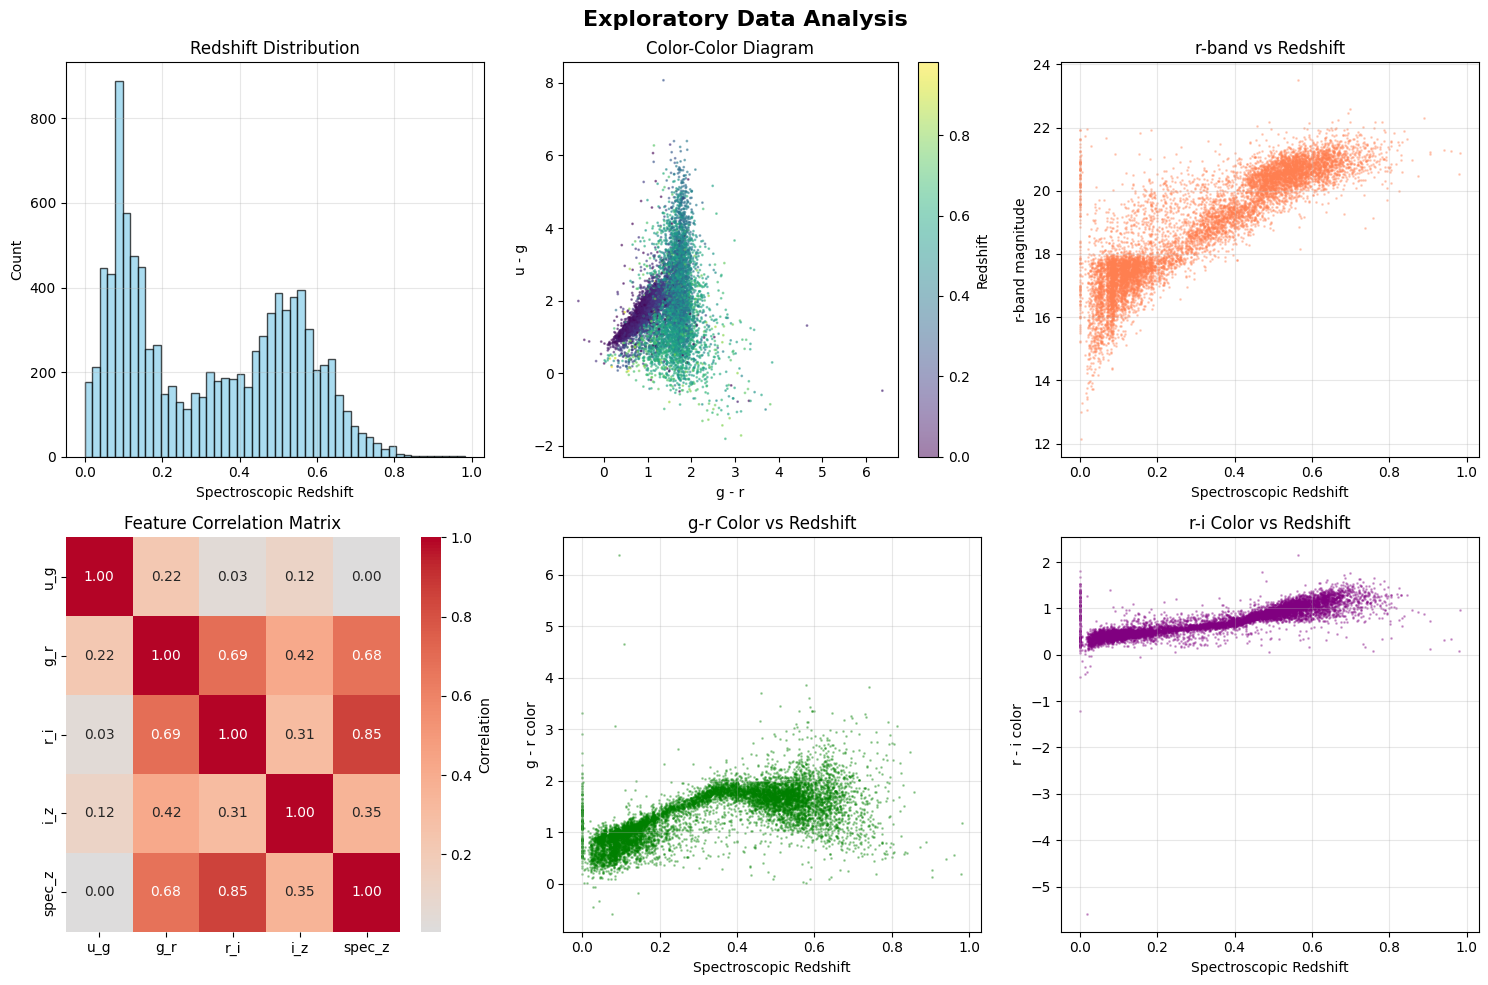

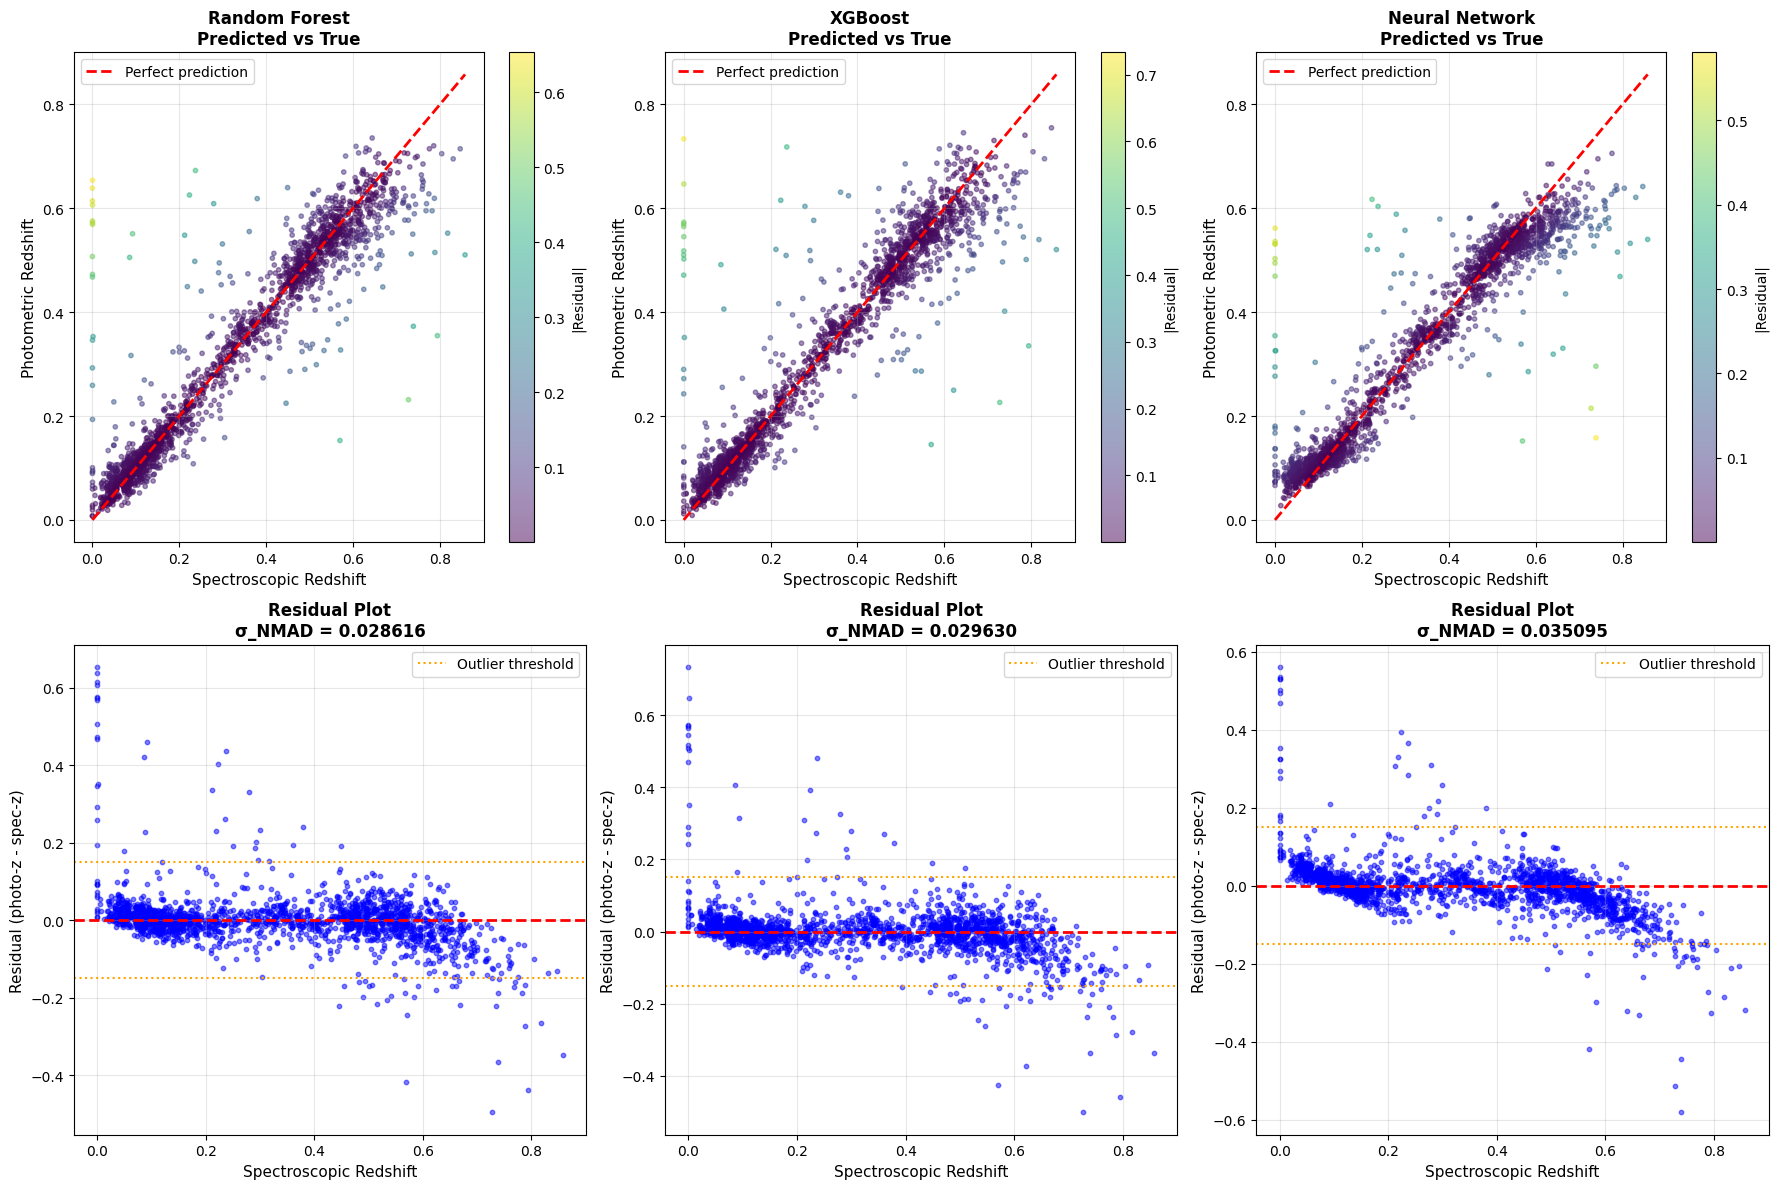

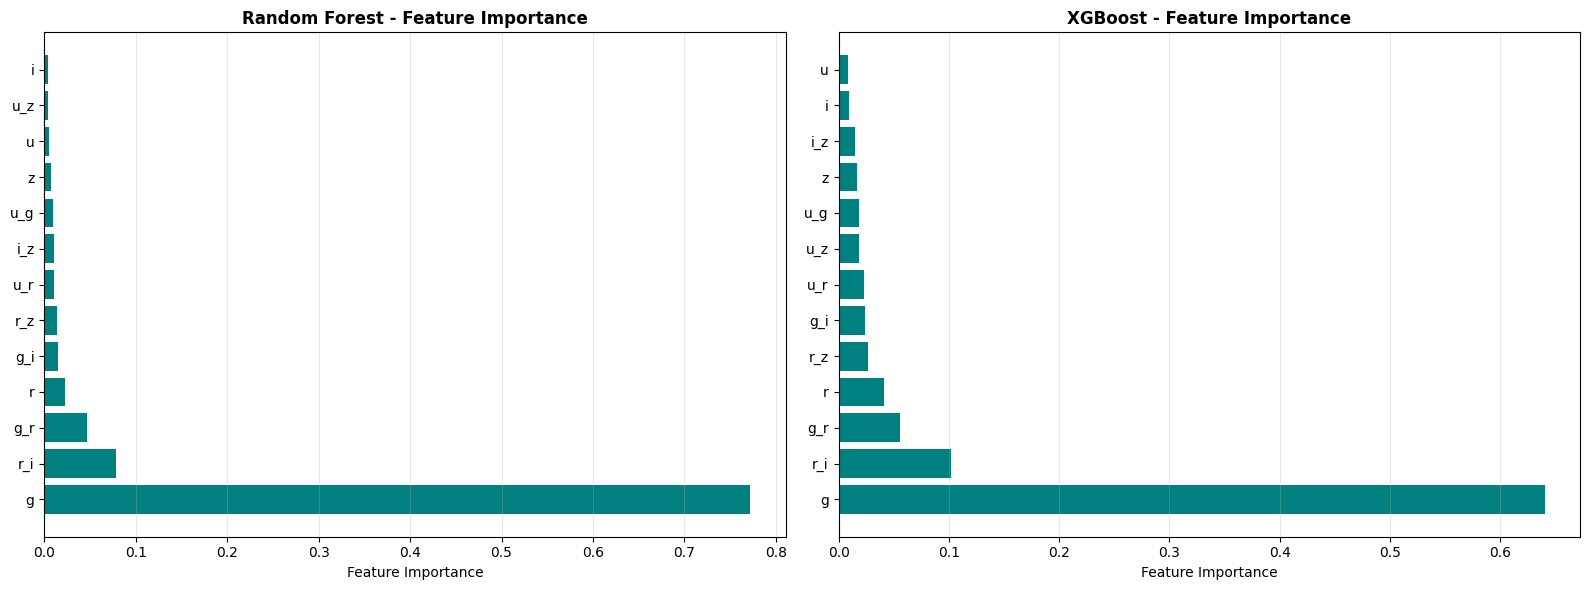

In [3]:
"""
Complete Photometric Redshift Estimation Pipeline
Using SDSS Data and Machine Learning

This script performs:
1. Data extraction from SDSS via SQL query
2. Data preprocessing and feature engineering
3. Exploratory Data Analysis
4. Training multiple ML models (Random Forest, XGBoost, Neural Network)
5. Evaluation and comparison
6. Visualization of results
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# For SDSS data access
from astroquery.sdss import SDSS
from astropy import coordinates as coords

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Install with: pip install xgboost")

# Neural Network
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not installed. Install with: pip install tensorflow")

print("=" * 80)
print("PHOTOMETRIC REDSHIFT ESTIMATION PIPELINE")
print("=" * 80)

# ============================================================================
# STEP 1: DATA EXTRACTION FROM SDSS
# ============================================================================
print("\n[STEP 1] Extracting data from SDSS...")

# SQL query to get photometric and spectroscopic data
# We'll get galaxies with both photometry and spectroscopic redshifts
query = """
SELECT TOP 10000
    p.objid, p.ra, p.dec,
    p.u, p.g, p.r, p.i, p.z,
    p.err_u, p.err_g, p.err_r, p.err_i, p.err_z,
    p.petroRad_r, p.petroR50_r, p.petroR90_r,
    s.z as spec_z, s.zErr as spec_z_err,
    p.type, p.clean
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE
    p.type = 3
    AND p.clean = 1
    AND s.z BETWEEN 0.0 AND 1.0
    AND s.zErr < 0.01
    AND p.u > 0 AND p.g > 0 AND p.r > 0 AND p.i > 0 AND p.z > 0
    AND p.err_u > 0 AND p.err_g > 0 AND p.err_r > 0 AND p.err_i > 0 AND p.err_z > 0
"""

print("Querying SDSS database (this may take a minute)...")
try:
    result = SDSS.query_sql(query)
    df = result.to_pandas()
    print(f"Successfully retrieved {len(df)} galaxies from SDSS")
except Exception as e:
    print(f"Error querying SDSS: {e}")
    print("Creating synthetic data for demonstration...")
    # Create synthetic data if query fails
    np.random.seed(42)
    n_samples = 5000
    spec_z = np.random.uniform(0, 1, n_samples)
    df = pd.DataFrame({
        'objid': range(n_samples),
        'u': 20 + 2*spec_z + np.random.normal(0, 0.3, n_samples),
        'g': 19 + 1.5*spec_z + np.random.normal(0, 0.2, n_samples),
        'r': 18 + spec_z + np.random.normal(0, 0.15, n_samples),
        'i': 17.5 + 0.8*spec_z + np.random.normal(0, 0.15, n_samples),
        'z': 17 + 0.6*spec_z + np.random.normal(0, 0.15, n_samples),
        'err_u': np.random.uniform(0.01, 0.1, n_samples),
        'err_g': np.random.uniform(0.01, 0.08, n_samples),
        'err_r': np.random.uniform(0.01, 0.06, n_samples),
        'err_i': np.random.uniform(0.01, 0.06, n_samples),
        'err_z': np.random.uniform(0.01, 0.06, n_samples),
        'spec_z': spec_z,
        'spec_z_err': np.random.uniform(0.001, 0.01, n_samples),
        'petroRad_r': np.random.uniform(1, 10, n_samples),
    })

print(f"\nDataset shape: {df.shape}")
print(f"Redshift range: {df['spec_z'].min():.3f} to {df['spec_z'].max():.3f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================
print("\n[STEP 2] Feature Engineering...")

# Create color features (differences between magnitudes)
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']
df['u_r'] = df['u'] - df['r']
df['g_i'] = df['g'] - df['i']
df['r_z'] = df['r'] - df['z']

# Additional features
df['u_z'] = df['u'] - df['z']

# Select features for modeling
feature_cols = ['u', 'g', 'r', 'i', 'z',
                'u_g', 'g_r', 'r_i', 'i_z',
                'u_r', 'g_i', 'r_z', 'u_z']

# Check for missing values
df = df.dropna(subset=feature_cols + ['spec_z'])

X = df[feature_cols].values
y = df['spec_z'].values

print(f"Features: {feature_cols}")
print(f"Final dataset size: {len(X)} samples")

# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================================
print("\n[STEP 3] Exploratory Data Analysis...")

# Create figure for EDA
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Redshift distribution
axes[0, 0].hist(y, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Spectroscopic Redshift')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Redshift Distribution')
axes[0, 0].grid(alpha=0.3)

# 2. Color-color diagram
axes[0, 1].scatter(df['g_r'], df['u_g'], c=y, cmap='viridis', s=1, alpha=0.5)
axes[0, 1].set_xlabel('g - r')
axes[0, 1].set_ylabel('u - g')
axes[0, 1].set_title('Color-Color Diagram')
cbar1 = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar1.set_label('Redshift')

# 3. r-band vs redshift
axes[0, 2].scatter(y, df['r'], s=1, alpha=0.3, color='coral')
axes[0, 2].set_xlabel('Spectroscopic Redshift')
axes[0, 2].set_ylabel('r-band magnitude')
axes[0, 2].set_title('r-band vs Redshift')
axes[0, 2].grid(alpha=0.3)

# 4. Correlation heatmap (subset of features)
corr_features = ['u_g', 'g_r', 'r_i', 'i_z', 'spec_z']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Feature Correlation Matrix')

# 5. Color vs redshift
axes[1, 1].scatter(y, df['g_r'], s=1, alpha=0.3, color='green')
axes[1, 1].set_xlabel('Spectroscopic Redshift')
axes[1, 1].set_ylabel('g - r color')
axes[1, 1].set_title('g-r Color vs Redshift')
axes[1, 1].grid(alpha=0.3)

# 6. Another color vs redshift
axes[1, 2].scatter(y, df['r_i'], s=1, alpha=0.3, color='purple')
axes[1, 2].set_xlabel('Spectroscopic Redshift')
axes[1, 2].set_ylabel('r - i color')
axes[1, 2].set_title('r-i Color vs Redshift')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("EDA plots saved as 'eda_analysis.png'")

# ============================================================================
# STEP 4: DATA SPLITTING AND PREPROCESSING
# ============================================================================
print("\n[STEP 4] Data Splitting and Preprocessing...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 5: MODEL TRAINING
# ============================================================================
print("\n[STEP 5] Training Machine Learning Models...")

results = {}

# ----------------------------------------------------------------------------
# 5.1: Random Forest
# ----------------------------------------------------------------------------
print("\n  [5.1] Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

results['Random Forest'] = {
    'predictions': y_pred_rf,
    'model': rf_model
}
print("  Random Forest training complete!")

# ----------------------------------------------------------------------------
# 5.2: XGBoost
# ----------------------------------------------------------------------------
if XGBOOST_AVAILABLE:
    print("\n  [5.2] Training XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    results['XGBoost'] = {
        'predictions': y_pred_xgb,
        'model': xgb_model
    }
    print("  XGBoost training complete!")

# ----------------------------------------------------------------------------
# 5.3: Neural Network
# ----------------------------------------------------------------------------
if TENSORFLOW_AVAILABLE:
    print("\n  [5.3] Training Neural Network...")

    # Build neural network
    nn_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    nn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Train with early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = nn_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()

    results['Neural Network'] = {
        'predictions': y_pred_nn,
        'model': nn_model,
        'history': history
    }
    print("  Neural Network training complete!")

# ============================================================================
# STEP 6: MODEL EVALUATION
# ============================================================================
print("\n[STEP 6] Model Evaluation...")
print("\n" + "="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate standard photo-z metrics"""
    residuals = y_pred - y_true

    # Standard metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Photo-z specific metrics
    # Normalized Median Absolute Deviation
    nmad = 1.48 * np.median(np.abs(residuals - np.median(residuals)))

    # Outlier fraction (|Δz| > 0.15)
    outlier_frac = np.sum(np.abs(residuals) > 0.15) / len(residuals) * 100

    # Bias
    bias = np.mean(residuals)

    print(f"\n{model_name}:")
    print(f"  RMSE:              {rmse:.6f}")
    print(f"  MAE:               {mae:.6f}")
    print(f"  R² Score:          {r2:.6f}")
    print(f"  σ_NMAD:            {nmad:.6f}")
    print(f"  Bias:              {bias:.6f}")
    print(f"  Outlier Fraction:  {outlier_frac:.2f}%")

    return {
        'rmse': rmse, 'mae': mae, 'r2': r2,
        'nmad': nmad, 'bias': bias, 'outlier_frac': outlier_frac
    }

metrics_summary = {}
for model_name, result in results.items():
    metrics = calculate_metrics(y_test, result['predictions'], model_name)
    metrics_summary[model_name] = metrics

print("\n" + "="*80)

# ============================================================================
# STEP 7: VISUALIZATIONS
# ============================================================================
print("\n[STEP 7] Creating Visualizations...")

n_models = len(results)
fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 12))
if n_models == 1:
    axes = axes.reshape(-1, 1)

for idx, (model_name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    residuals = y_pred - y_test

    # Scatter plot: predicted vs true
    ax1 = axes[0, idx]
    scatter = ax1.scatter(y_test, y_pred, c=np.abs(residuals),
                         cmap='viridis', s=10, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
    ax1.set_xlabel('Spectroscopic Redshift', fontsize=11)
    ax1.set_ylabel('Photometric Redshift', fontsize=11)
    ax1.set_title(f'{model_name}\nPredicted vs True', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('|Residual|')

    # Residual plot
    ax2 = axes[1, idx]
    ax2.scatter(y_test, residuals, s=10, alpha=0.5, color='blue')
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.axhline(y=0.15, color='orange', linestyle=':', lw=1.5, label='Outlier threshold')
    ax2.axhline(y=-0.15, color='orange', linestyle=':', lw=1.5)
    ax2.set_xlabel('Spectroscopic Redshift', fontsize=11)
    ax2.set_ylabel('Residual (photo-z - spec-z)', fontsize=11)
    ax2.set_title(f'Residual Plot\nσ_NMAD = {metrics_summary[model_name]["nmad"]:.6f}',
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
print("Prediction plots saved as 'model_predictions.png'")

# ============================================================================
# Feature Importance (for tree-based models)
# ============================================================================
if 'Random Forest' in results or 'XGBoost' in results:
    fig, axes = plt.subplots(1, sum([1 for m in ['Random Forest', 'XGBoost'] if m in results]),
                            figsize=(8*sum([1 for m in ['Random Forest', 'XGBoost'] if m in results]), 6))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    plot_idx = 0
    for model_name in ['Random Forest', 'XGBoost']:
        if model_name in results:
            importances = results[model_name]['model'].feature_importances_
            indices = np.argsort(importances)[::-1]

            axes[plot_idx].barh(range(len(feature_cols)), importances[indices], color='teal')
            axes[plot_idx].set_yticks(range(len(feature_cols)))
            axes[plot_idx].set_yticklabels([feature_cols[i] for i in indices])
            axes[plot_idx].set_xlabel('Feature Importance')
            axes[plot_idx].set_title(f'{model_name} - Feature Importance', fontweight='bold')
            axes[plot_idx].grid(alpha=0.3, axis='x')
            plot_idx += 1

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("Feature importance plots saved as 'feature_importance.png'")

# ============================================================================
# Model Comparison Summary
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame(metrics_summary).T
comparison_df = comparison_df.round(6)
print("\n", comparison_df.to_string())

# Find best model
best_model_rmse = comparison_df['rmse'].idxmin()
best_model_nmad = comparison_df['nmad'].idxmin()

print(f"\n🏆 Best model (RMSE): {best_model_rmse}")
print(f"🏆 Best model (σ_NMAD): {best_model_nmad}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  - eda_analysis.png: Exploratory data analysis plots")
print("  - model_predictions.png: Model prediction comparisons")
if 'Random Forest' in results or 'XGBoost' in results:
    print("  - feature_importance.png: Feature importance analysis")

print("\nKey Insights:")
print(f"  • Analyzed {len(df)} galaxies from SDSS")
print(f"  • Redshift range: {y.min():.3f} - {y.max():.3f}")
print(f"  • Best performing model: {best_model_nmad}")
print(f"  • Achieved σ_NMAD: {comparison_df.loc[best_model_nmad, 'nmad']:.6f}")
print(f"  • Outlier fraction: {comparison_df.loc[best_model_nmad, 'outlier_frac']:.2f}%")

plt.show()